In [1]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
from braincoder.optimize import ParameterFitter
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
assignment_data = np.load('resources/assignment3.npz')
stimulus = assignment_data['stimulus']  # shape (n_timepoints, n_pixels)
v1_ts = pd.DataFrame(assignment_data['v1_ts'])        # shape (n_timepoints, n_voxels)
x_coordinates = assignment_data['x_coordinates']    # shape (n_pixels_x, n_pixels_y)
y_coordinates = assignment_data['y_coordinates']    # shape (n_pixels_x, n_pixels_y)

grid_coordinates = np.stack((x_coordinates.ravel(), y_coordinates.ravel()), axis=-1).astype(np.float32)

In [3]:
# Set up model, including HRF
hrf_model = SPMHRFModel(tr=1.7, delay=4.5, dispersion=.5)
model = GaussianPRF2DWithHRF(grid_coordinates=grid_coordinates, hrf_model=hrf_model)

# Set up fitter
fitter = ParameterFitter(data=v1_ts, model=model, paradigm=stimulus)

# Define grid search parameters
mu_x = np.linspace(-3, 3, 10, dtype=np.float32)
mu_y = np.linspace(-3, 3, 10, dtype=np.float32)
sigma = np.linspace(0.1, 5, 10, dtype=np.float32)
baselines = [0.0]
amplitudes = [1.0]

# Do grid search using correlation cost (so baseline and amplitude do not matter)
grid_pars = fitter.fit_grid(mu_x, mu_y, sigma, baselines, amplitudes, use_correlation_cost=True)

 # Refine baseline and amplitude using OLS
grid_pars = fitter.refine_baseline_and_amplitude(grid_pars)

# Get rsq
r2_grid = fitter.get_rsq(grid_pars)
gd_pars = fitter.fit(init_pars=grid_pars)

r2_gd = fitter.get_rsq(gd_pars)

Working with chunk size of 1231
Using correlation cost!


2025-09-16 14:46:32.900080: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-16 14:46:32.900107: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-16 14:46:32.900129: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-16 14:46:32.900286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-16 14:46:32.900306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 14:46:34.499082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 2099


Current R2: 0.20084/Best R2: 0.20086: 100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s]


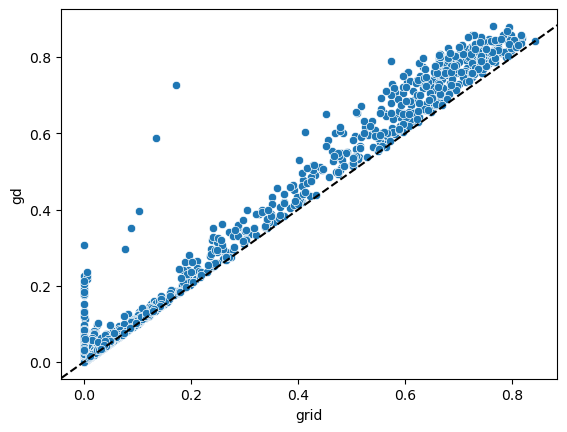

In [4]:
r2 = pd.concat((r2_grid, r2_gd), keys=['grid', 'gd'], names=['optimisation'], axis=1)

sns.scatterplot(x='grid', y='gd', data=r2)

plt.axline((0, 0), slope=1, color='k', linestyle='--')

# Assignment 4: Decode Visual Stimulus

---

## Objective
In this assignment, you will use the `braincoder` package to decode visual stimuli from your fMRI data (`v1_ts`). You will fit an encoding model, estimate the residual noise distribution, and then decode the stimulus while exploring the effects of regularization and model choice.

---

## Instructions

For reference, consult the following example:
[braincoder Decoding Example](https://braincoder-devs.github.io/auto_examples/00_encodingdecoding/decode_v1.html)

---

## Tasks

#### **1. Fit Encoding Model and Residual Noise**
- Fit a **Gaussian PRF model** to your `v1_ts` data.
- Compute the \( R^2 \) for each voxel.
- Select the **top 50, 100, and 250 voxels** with the highest \( R^2 \).
- Use `ResidualFitter` to estimate the **residual noise distribution** for the selected voxels.

---

#### **2. Decode the Stimulus**
- Use the `StimulusFitter` class to decode the stimulus from the selected voxels.
- Generate a **movie of the decoded stimulus** for each voxel subset (50, 100, 250).

---

#### **3. Experiment with Regularization**
Here’s a neutral, definition-only blurb for your assignment:

---

### **L1 and L2 Norms**
- **L1 norm**: Adds the sum of the **absolute values** of the stimulus parameters to the cost function:
  $$
  \text{Penalty} = \lambda \sum |S_i|
  $$
- **L2 norm**: Adds the sum of the **squared values** of the stimulus parameters to the cost function:
  $$
  \text{Penalty} = \lambda \sum S_i^2
  $$
where $\lambda$ is a regularization parameter.

- Decode the stimulus using:
  - **L1 norm** (`l1_norm=0.1`).
  - **L2 norm** (`l2_norm=0.1`).
- Generate movies for both regularization types.

---

#### **4. Compare Models**
- Repeat the decoding using a **Difference of Gaussians (DoG) PRF model**.
- Generate a movie of the decoded stimulus for the DoG model.

---
### Questions to Answer
- How does the number of voxels affect the quality of the decoded movie?
- How does L1 vs. L2 regularization influence the decoded stimulus? Consider sparsity and smoothness.
- How does using a DoG model change the reconstructed stimulus compared to the Gaussian PRF model?

---
### Deliverables
- A Jupyter Notebook containing:
  - Code for voxel selection, residual fitting, decoding, and movie generation.
  - Movies of the decoded stimuli (save as `.mp4` or `.gif`).
  - Answers to the questions above.

---
### Tips
- Use `braincoder.optimize.ResidualFitter` to fit the residual noise distribution.
- Use `braincoder.optimize.StimulusFitter` for decoding.
- For creating movies, you can use:
  ```python
  from matplotlib.animation import FuncAnimation
  from IPython.display import HTML

  def make_movie(decoded_stimulus):
      fig = plt.figure()
      ims = []
      for frame in decoded_stimulus:
          im = plt.imshow(frame, animated=True)
          ims.append([im])
      ani = FuncAnimation(fig, ims, interval=100, blit=True)
      return HTML(ani.to_html5_video())
  ```